# Choose Cluster

In [1]:
cluster_input = 7

# Quick Links

<ol>
    <li><a href=#prep_main_scores>Prepare GkmExplain, ISM, and deltaSVM Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Magnitude and Prominence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

from matplotlib import pyplot as plt
from plotnine import *
from viz_preprocess import *
from viz_sequence import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

## Addresses

In [3]:
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}
celltype = clust_to_celltype[cluster_input]
observed_base = '/mnt/lab_data3/soumyak/adpd/'
observed_effect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
observed_noneffect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
additional_observed_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/additional_snps/'
additional_observed_effect_fasta = additional_observed_base + 'explain_inputs/Cluster' + cluster + '.effect.fasta'
additional_observed_noneffect_fasta = additional_observed_base + 'explain_inputs/Cluster' + cluster + '.noneffect.fasta'

## Get Input Sequences

In [4]:
observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_effect_fasta)) if i%2==1]
additional_observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(additional_observed_effect_fasta)) if i%2==1]
all_observed_effect_seqs = observed_effect_seqs + additional_observed_effect_seqs
observed_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in all_observed_effect_seqs]

print('Num Observed effect sequences:', '\t', '\t', len(observed_effect_onehot))

observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_noneffect_fasta)) if i%2==1]
additional_observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(additional_observed_noneffect_fasta)) if i%2==1]
all_observed_noneffect_seqs = observed_noneffect_seqs + additional_observed_noneffect_seqs
observed_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in all_observed_noneffect_seqs]

print('Num Observed noneffect sequences:', '\t', len(observed_noneffect_onehot))

Num Observed effect sequences: 	 	 380
Num Observed noneffect sequences: 	 380


# Prepare Observed GkmExplain, ISM, and deltaSVM Scores <a name='prep_main_scores' />

In [5]:
merged_observed_effect_scores = np.zeros(shape=(len(observed_effect_onehot), 1000, 4))
merged_observed_noneffect_scores = np.zeros(shape=(len(observed_noneffect_onehot), 1000, 4))
merged_observed_explain_scores = np.zeros(shape=(len(observed_effect_onehot),))

for fold in range(10):
    observed_effect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    observed_effect_scores = get_hyp_scores(observed_effect_file, observed_effect_seqs)
    observed_effect_scores = np.array(observed_effect_scores)
    additional_observed_effect_file = additional_observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores'
    additional_observed_effect_scores = get_hyp_scores(additional_observed_effect_file, additional_observed_effect_seqs)
    additional_observed_effect_scores = np.array(additional_observed_effect_scores)
    observed_effect_scores = np.concatenate((observed_effect_scores, additional_observed_effect_scores))
    merged_observed_effect_scores = merged_observed_effect_scores + observed_effect_scores
        
    observed_noneffect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    observed_noneffect_scores = get_hyp_scores(observed_noneffect_file, observed_noneffect_seqs)
    observed_noneffect_scores = np.array(observed_noneffect_scores)
    additional_observed_noneffect_file = additional_observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores'
    additional_observed_noneffect_scores = get_hyp_scores(additional_observed_noneffect_file, additional_observed_noneffect_seqs)
    additional_observed_noneffect_scores = np.array(additional_observed_noneffect_scores)
    observed_noneffect_scores = np.concatenate((observed_noneffect_scores, additional_observed_noneffect_scores))
    merged_observed_noneffect_scores = merged_observed_noneffect_scores + observed_noneffect_scores
           
    observed_explain_scores = []
    
    for i,j in enumerate(observed_effect_scores): # iterate over sequences
        observed_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                observed_effect_scores[i][475:525]]))
        observed_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    observed_noneffect_scores[i][475:525]]))
        observed_explain_score_seq = observed_50bp_imp_effect - observed_50bp_imp_noneffect
        observed_explain_scores.append(observed_explain_score_seq)
    
    merged_observed_explain_scores = merged_observed_explain_scores + np.array(observed_explain_scores)
    
merged_observed_effect_scores = merged_observed_effect_scores / (fold + 1)
merged_observed_noneffect_scores = merged_observed_noneffect_scores / (fold + 1)
merged_observed_explain_scores = merged_observed_explain_scores / (fold + 1)

print('Num Observed GkmExplain scores:', '\t', len(merged_observed_explain_scores))
print('Num Observed Effect scores:', '\t', '\t', len(merged_observed_effect_scores))
print('Num Observed Non-Effect scores:', '\t', len(merged_observed_noneffect_scores))

#--------------------------------------------------------#

merged_observed_ism_scores = np.zeros(shape=(len(observed_effect_onehot),))
merged_observed_delta_scores = np.zeros(shape=(len(observed_effect_onehot),))

for fold in range(10):
    observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    additional_observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(additional_observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    observed_ism_scores = np.concatenate((observed_ism_scores, additional_observed_ism_scores))
    merged_observed_ism_scores = merged_observed_ism_scores + observed_ism_scores
    
    observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    additional_observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(additional_observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    observed_delta_scores = np.concatenate((observed_delta_scores, additional_observed_delta_scores))
    merged_observed_delta_scores = merged_observed_delta_scores + observed_delta_scores
        
merged_observed_ism_scores = merged_observed_ism_scores / (fold + 1)
merged_observed_delta_scores = merged_observed_delta_scores / (fold + 1)

print('Num Observed ISM scores:', '\t', '\t', len(merged_observed_ism_scores))
print('Num Observed deltaSVM scores:', '\t', '\t', len(merged_observed_delta_scores))

Num Observed GkmExplain scores: 	 380
Num Observed Effect scores: 	 	 380
Num Observed Non-Effect scores: 	 380


Num Observed ISM scores: 	 	 380
Num Observed deltaSVM scores: 	 	 380


# Prepare Null GkmExplain, ISM, and deltaSVM Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 7180000
Num Null GkmExplain scores: 	 35900


Num Null ISM scores: 	 	 35900
Num Null deltaSVM scores: 	 35900


# Get Observed Magnitude and Prominence Scores <a name='prep_conf_scores' />

In [7]:
observed_confidence_dict = {'observed_seqlet_start': [], 'observed_seqlet_end': [],
                            'observed_seqlet_effect': [], 'observed_seqlet_noneffect': [],
                            'observed_bg_effect': [], 'observed_bg_noneffect': [],
                            'observed_magnitude_score': [], 'observed_prominence_score': [],
                            'observed_active_allele': [], 'observed_inactive_allele': [],
                            'observed_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(all_observed_effect_seqs)):
    observed_per_seq_dict = {'observed_scores_active': [], 'observed_scores_inactive': [],
                             'observed_scores_effect': [], 'observed_scores_noneffect': [],
                             'observed_active_allele': ''}
    observed_seqlet_start = 0
    observed_seqlet_end = 0
    observed_seqlet_effect = 0
    observed_seqlet_noneffect = 0
    observed_bg_effect = 0
    observed_bg_noneffect = 0
    
    observed_effect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_effect_scores[seq][475:525]]))
    observed_noneffect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_noneffect_scores[seq][475:525]]))
    observed_per_seq_dict['observed_scores_effect'] = [np.sum(j) for j in merged_observed_effect_scores[seq]]
    observed_per_seq_dict['observed_scores_noneffect'] = [np.sum(j) for j in merged_observed_noneffect_scores[seq]]
    if observed_effect_total > observed_noneffect_total:
        observed_per_seq_dict['observed_active_allele'] = 'effect'
        observed_per_seq_dict['observed_inactive_allele'] = 'noneffect'
        observed_confidence_dict['observed_active_allele'].append('effect')
        observed_confidence_dict['observed_inactive_allele'].append('noneffect')
    else:
        observed_per_seq_dict['observed_active_allele'] = 'noneffect'
        observed_per_seq_dict['observed_inactive_allele'] = 'effect'
        observed_confidence_dict['observed_active_allele'].append('noneffect')
        observed_confidence_dict['observed_inactive_allele'].append('effect')
    observed_per_seq_dict['observed_scores_active'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_active_allele']]
    observed_per_seq_dict['observed_scores_inactive'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_inactive_allele']]
    
    start = 499
    end = 500
    while True:
        if observed_per_seq_dict['observed_scores_active'][start - 1] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if observed_per_seq_dict['observed_scores_active'][end] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        observed_seqlet_len = end - start
        if (observed_seqlet_len) < 7:
            if (end - 500) > (499 - start):
                observed_seqlet_start = start - math.ceil((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.floor((7 - observed_seqlet_len) / 2)
            else:           
                observed_seqlet_start = start - math.floor((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.ceil((7 - observed_seqlet_len) / 2)
        else:
            observed_seqlet_start = start
            observed_seqlet_end = end
    else:
        observed_seqlet_start = start - 3
        observed_seqlet_end = end + 3
    
    observed_confidence_dict['observed_seqlet_start'].append(observed_seqlet_start)
    observed_confidence_dict['observed_seqlet_end'].append(observed_seqlet_end)
    observed_confidence_dict['observed_seqlet_len'].append(observed_seqlet_end - observed_seqlet_start)
    
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active'][observed_seqlet_start:observed_seqlet_end]):
        if observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_effect += observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start]
        if observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start]
        assert j == observed_per_seq_dict['observed_scores_active'][i+observed_seqlet_start]
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active']):
        if observed_per_seq_dict['observed_scores_effect'][i] >= 0:
            observed_bg_effect += observed_per_seq_dict['observed_scores_effect'][i]
        if observed_per_seq_dict['observed_scores_noneffect'][i] >= 0:
            observed_bg_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i]
        assert j == observed_per_seq_dict['observed_scores_active'][i]
    
    observed_magnitude_score = observed_seqlet_effect - observed_seqlet_noneffect
    observed_prominence_score = (observed_seqlet_effect / observed_bg_effect) - (observed_seqlet_noneffect / observed_bg_noneffect)
    
    observed_confidence_dict['observed_seqlet_effect'].append(observed_seqlet_effect)
    observed_confidence_dict['observed_seqlet_noneffect'].append(observed_seqlet_noneffect)
    observed_confidence_dict['observed_bg_effect'].append(observed_bg_effect)
    observed_confidence_dict['observed_bg_noneffect'].append(observed_bg_noneffect)
    observed_confidence_dict['observed_magnitude_score'].append(observed_magnitude_score)
    observed_confidence_dict['observed_prominence_score'].append(observed_prominence_score)

print('Mean observed seqlet length:', '\t', '\t', statistics.mean(observed_confidence_dict['observed_seqlet_len']))
print('Median observed seqlet length:', '\t', '\t', statistics.median(observed_confidence_dict['observed_seqlet_len']))
print('St. Dev observed seqlet length:', '\t', statistics.stdev(observed_confidence_dict['observed_seqlet_len']))
print('Mode observed seqlet length:', '\t', '\t', statistics.mode(observed_confidence_dict['observed_seqlet_len']))
print('Max observed seqlet length:', '\t', '\t', max(observed_confidence_dict['observed_seqlet_len']))
print('Min observed seqlet lenght:', '\t', '\t', min(observed_confidence_dict['observed_seqlet_len']))

Per-base Importance Score Threshold:  	 0.030029807499999832


Mean observed seqlet length: 	 	 7.997368421052632
Median observed seqlet length: 	 	 7.0
St. Dev observed seqlet length: 	 2.900731128117204
Mode observed seqlet length: 	 	 7
Max observed seqlet length: 	 	 26
Min observed seqlet lenght: 	 	 7


# Get Null Magnitude and Prominence Scores

In [8]:
null_confidence_dict = {'null_seqlet_start': [], 'null_seqlet_end': [],
                        'null_seqlet_effect': [], 'null_seqlet_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_seqlet_start = 0
    null_seqlet_end = 0
    null_seqlet_effect = 0
    null_seqlet_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum([max(0,i) for i in merged_null_effect_scores[seq][75:125]])
    null_noneffect_total = sum([max(0,i) for i in merged_null_noneffect_scores[seq][75:125]])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total > null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 100
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        null_seqlet_len = end - start
        if (null_seqlet_len) < 7:
            if (end - 100) > (99 - start):
                null_seqlet_start = start - math.ceil((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.floor((7 - null_seqlet_len) / 2)
            else:
                null_seqlet_start = start - math.floor((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.ceil((7 - null_seqlet_len) / 2)
        else:
            null_seqlet_start = start
            null_seqlet_end = end
    else:
        null_seqlet_start = start - 3
        null_seqlet_end = end + 3
    
    null_confidence_dict['null_seqlet_start'].append(null_seqlet_start)
    null_confidence_dict['null_seqlet_end'].append(null_seqlet_end)
    null_confidence_dict['null_seqlet_len'].append(null_seqlet_end - null_seqlet_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_seqlet_start:null_seqlet_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_seqlet_start] >= 0:
            null_seqlet_effect += null_per_seq_dict['null_scores_effect'][i+null_seqlet_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start] >= 0:
            null_seqlet_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_seqlet_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_seqlet_effect - null_seqlet_noneffect
    null_prominence_score = (null_seqlet_effect / null_bg_effect) - (null_seqlet_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_seqlet_effect'].append(null_seqlet_effect)
    null_confidence_dict['null_seqlet_noneffect'].append(null_seqlet_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null seqlet length:', '\t', '\t', statistics.mean(null_confidence_dict['null_seqlet_len']))
print('Median Null seqlet length:', '\t', '\t', statistics.median(null_confidence_dict['null_seqlet_len']))
print('St. Dev Null seqlet length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_seqlet_len']))
print('Mode Null seqlet length:', '\t', '\t', statistics.mode(null_confidence_dict['null_seqlet_len']))
print('Max Null seqlet length:', '\t', '\t', max(null_confidence_dict['null_seqlet_len']))
print('Min Null seqlet lenght:', '\t', '\t', min(null_confidence_dict['null_seqlet_len']))

Per-base Importance Score Threshold:  	 0.030029807499999832


Mean Null seqlet length: 	 	 7.667966573816156
Median Null seqlet length: 	 	 7.0
St. Dev Null seqlet length: 	 	 2.2072495994267247
Mode Null seqlet length: 	 	 7
Max Null seqlet length: 	 	 35
Min Null seqlet lenght: 	 	 7


# Make Observed Scores DataFrame <a name='prep_score_df' />

In [9]:
orig_snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
additional_snp_scores = pd.read_csv('/oak/stanford/groups/akundaje/projects/'
                                    + 'alzheimers_parkinsons/additional_snps/'
                                    + 'snps_in_overlap_peaks/Cluster'
                                    + cluster + '.new.overlap.expanded.snps.hg38.bed', sep='\t')
snp_scores = pd.concat([orig_snp_scores, additional_snp_scores], ignore_index=True)

full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')
additional_full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                                       + 'snps_final/New_ML_SNPs.tsv', sep='\t')
idr_snps = [i.strip() for i in open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/IDR_snps.txt')]

snp_scores['gc'] = [((all_observed_noneffect_seqs[index].count('G') + all_observed_noneffect_seqs[index].count('C'))
                     / len(all_observed_noneffect_seqs[index])) for index in range(len(all_observed_noneffect_seqs))]
snp_scores['explain_score'] = merged_observed_explain_scores
snp_scores['ism_score'] = merged_observed_ism_scores
snp_scores['delta_score'] = merged_observed_delta_scores
snp_scores['magnitude_score'] = observed_confidence_dict['observed_magnitude_score']
snp_scores['prominence_score'] = observed_confidence_dict['observed_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_seqlet = []
inactive_seqlet = []
diff_seqlet = []
in_idr_peak = []

for index,row in snp_scores.iterrows():
    best_gwas = row['source_gwas']
    lowest_pval = float(row['pvalue']) if (row['pvalue'] != '.') else 1.0
    has_coloc = False
    locus = row['locus_num']
    na_gwas = 'NA'
    na_pval = 'NA'
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] <= lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        elif math.isnan(rw['pvalue']):
            na_gwas = rw['source_gwas']
            na_pval = 'NA'
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    if best_gwas == '':
        gwas.append(na_gwas)
        gwas_pval.append(na_pval)
    else:
        gwas.append(best_gwas)
        gwas_pval.append(lowest_pval)
    for ind,rw in additional_full_snp_list.loc[additional_full_snp_list['SNP_rsID']==row['rsid']].iterrows():
        if has_coloc == False:
            if rw['Has_Coloc'] == True:
                has_coloc = True
    coloc.append(has_coloc)
    locus_num.append(locus)
    if row['rsid'] in idr_snps:
        in_idr_peak.append(True)
    else:
        in_idr_peak.append(False)
    if observed_confidence_dict['observed_active_allele'][index] == 'effect':
        active_seq = all_observed_effect_seqs[index]
        inactive_seq = all_observed_noneffect_seqs[index]
    else:
        active_seq = all_observed_noneffect_seqs[index]
        inactive_seq = all_observed_effect_seqs[index]
    seqlet_start = observed_confidence_dict['observed_seqlet_start'][index]
    seqlet_end = observed_confidence_dict['observed_seqlet_end'][index]
    active_seqlet.append(active_seq[seqlet_start:seqlet_end])
    inactive_seqlet.append(inactive_seq[seqlet_start:seqlet_end])
    diff_seqlet.append(active_seq[seqlet_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:seqlet_end])
    if row['effect'] == 'NAN':
        snp_scores.at[index, 'effect'] = 'NA'
    if row['noneffect'] == 'NAN':
        snp_scores.at[index, 'noneffect'] = 'NA'

snp_scores['locus_num'] = locus_num
snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['in_idr_peak'] = in_idr_peak
snp_scores['active_seqlet'] = active_seqlet
snp_scores['inactive_seqlet'] = inactive_seqlet
snp_scores['diff_seqlet'] = diff_seqlet
snp_scores['active_allele'] = observed_confidence_dict['observed_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
#snp_scores = snp_scores.loc[snp_scores['effect'] != 'NA']
#snp_scores = snp_scores.loc[snp_scores['noneffect'] != 'NA']

print('Observed Scores:')
print()
display(snp_scores.head())
print()
print('Shape: ', snp_scores.shape)

Observed Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,in_idr_peak,active_seqlet,inactive_seqlet,diff_seqlet,active_allele
0,chr1,154865462,154865463,rs116839452,G,A,A,G,A,G,+,10,0.521,0.092447,0.144938,0.830858,0.053354,0.029302,4,Nalls_23andMe,1.607560e-01,False,True,ATAGTAA,ATAATAA,ATA(G/A)TAA,effect
1,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,-0.070747,-0.110844,-0.654133,-0.003850,-0.001765,7,23andme_PD_hg38,1.639030e-14,False,True,CCAAGGT,CCAGGGT,CCA(A/G)GGT,noneffect
2,chr1,161185601,161185602,rs4575098,A,G,G,A,G,A,+,129,0.433,-0.352512,-0.549239,-3.155983,-0.000949,-0.000464,1,Alzheimers_Jansen_2018,2.050000e-10,True,True,AATGTTA,AATATTA,AAT(G/A)TTA,noneffect
3,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,-0.236362,-0.376192,-2.183716,-0.119235,-0.040011,7,Nalls_23andMe,5.636480e-02,False,True,GACAGTT,GACCGTT,GAC(A/C)GTT,noneffect
4,chr1,205694349,205694350,rs12118655,G,A,A,G,A,G,+,17,0.518,0.124886,0.195090,1.129802,0.000000,0.000000,4,Nalls_23andMe,2.650000e-07,False,True,GCTGTAT,GCTATAT,GCT(G/A)TAT,effect



Shape:  (380, 27)


# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in orig_snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = observed_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
print()
print('Shape: ', null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs116839452,0.035069,0.052252,0.293885,0.018925,0.013326,0.521,4
1,rs12726330,0.119963,0.178276,1.022025,0.036060,0.024783,0.628,7
2,rs4575098,0.071315,0.105490,0.602150,0.038360,0.044947,0.433,1
3,rs12119232,-0.291297,-0.433260,-2.478478,-0.035108,-0.034527,0.626,7
4,rs12118655,0.019041,0.022046,0.143499,0.010261,0.003330,0.518,4



Shape:  (35900, 8)


## Get Null Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.408684
null_ism_score          -0.608454
null_delta_score        -3.519051
null_magnitude_score    -0.217434
null_prominence_score   -0.138072
gc                       0.339000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.392710
null_ism_score           0.585569
null_delta_score         3.380175
null_magnitude_score     0.202078
null_prominence_score    0.130259
gc                       0.719000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.320
0.1    0.410
0.2    0.467
0.3    0.488
0.4    0.517
0.5    0.543
0.6    0.570
0.7    0.591
0.8    0.628
0.9    0.675
1.0    0.784
Name: gc, dtype: float64

## Check if Null Scores are Distributed Identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,0.000332,1.000000,1.0,1.0,1.0000,1.0,1.0000
1,1.000000,1.000000,1.0,1.000000,0.004211,1.0,1.0,1.0000,1.0,1.0000
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
3,0.000332,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
4,1.000000,0.004211,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,0.0003
8,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.0000,1.0,1.0000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.0003,1.0,1.0000


Significant Differences:  3

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,0.000332,1.000000,1.0,1.0,1.000000,1.0,1.000000
1,1.000000,1.000000,1.0,1.000000,0.004211,1.0,1.0,1.000000,1.0,1.000000
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
3,0.000332,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
4,1.000000,0.004211,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.000489
8,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000489,1.0,1.000000


Significant Differences:  3

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,0.000449,1.000000,1.0,1.0,1.000000,1.0,1.000000
1,1.000000,1.000000,1.0,1.000000,0.003288,1.0,1.0,1.000000,1.0,1.000000
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
3,0.000449,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
4,1.000000,0.003288,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.000223
8,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.000223,1.0,1.000000


Significant Differences:  3

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,0.000002,1.000000,1.0,1.0,1.00000,1.0,1.00000
1,1.000000,1.000000,1.0,1.000000,0.052669,1.0,1.0,1.00000,1.0,1.00000
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
3,0.000002,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
4,1.000000,0.052669,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,0.00001
8,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.0,1.00000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.00001,1.0,1.00000


Significant Differences:  2

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,0.000105,1.000000,1.0,1.0,1.000000,1.0,1.000000
1,1.000000,1.000000,1.0,1.000000,0.049454,1.0,1.0,1.000000,1.0,1.000000
2,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
3,0.000105,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
4,1.000000,0.049454,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
5,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
6,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
7,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,0.013635
8,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000000
9,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,0.013635,1.0,1.000000


Significant Differences:  1


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

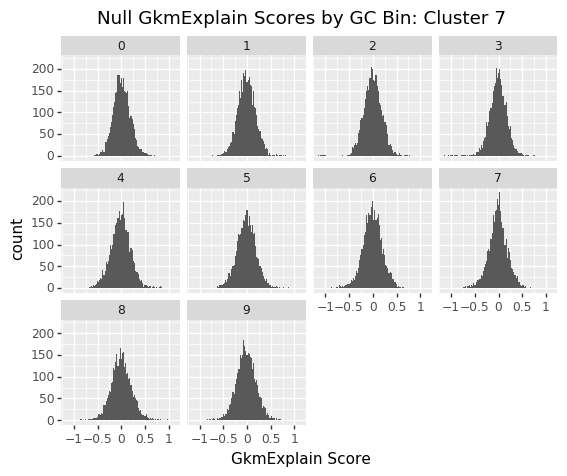

<ggplot: (8765118054243)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.0062121875550622836
Stdev: 	 0.178634464854653

KstestResult(statistic=0.003652081911614702, pvalue=0.7245569670831065)



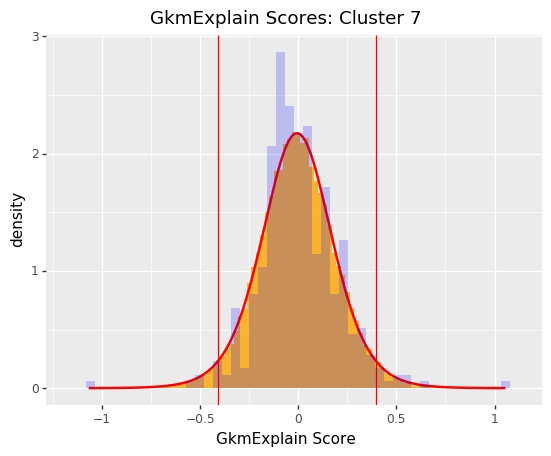

<ggplot: (-9223363271932664965)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

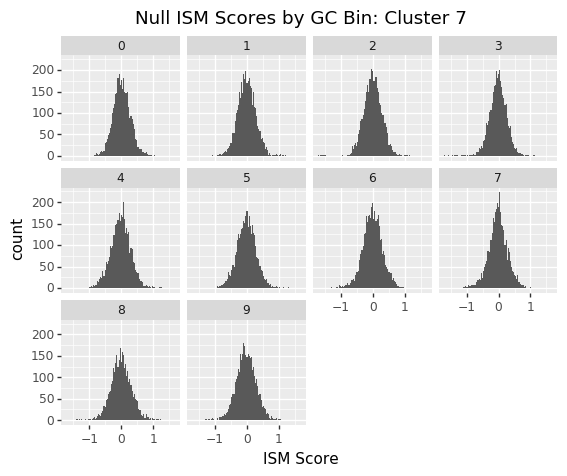

<ggplot: (-9223363271932616623)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.009296191378290627
Stdev: 	 0.266011713372631

KstestResult(statistic=0.0036565313803280652, pvalue=0.723162709974743)



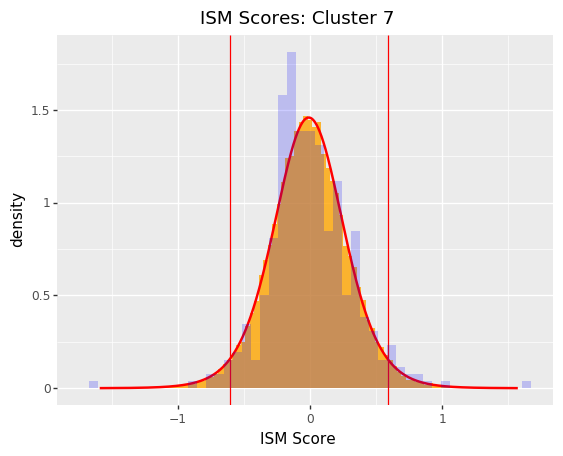

<ggplot: (8764921791801)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

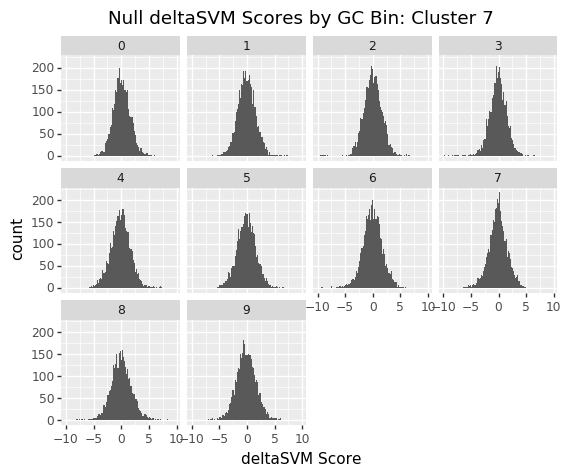

<ggplot: (-9223363271932616539)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.05348569086000465
Stdev: 	 1.5380224099700728

KstestResult(statistic=0.0038685109958838115, pvalue=0.6558635082091242)



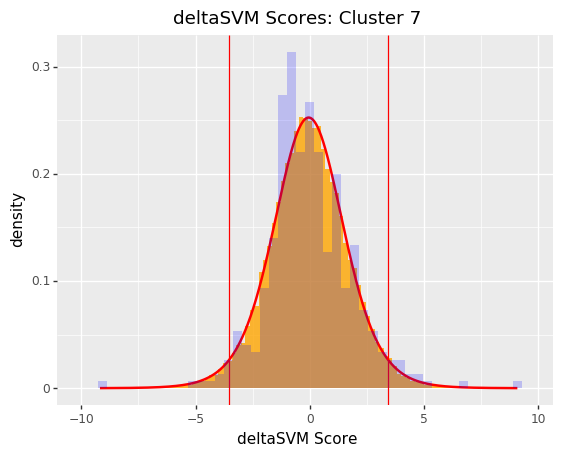

<ggplot: (8764921437304)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

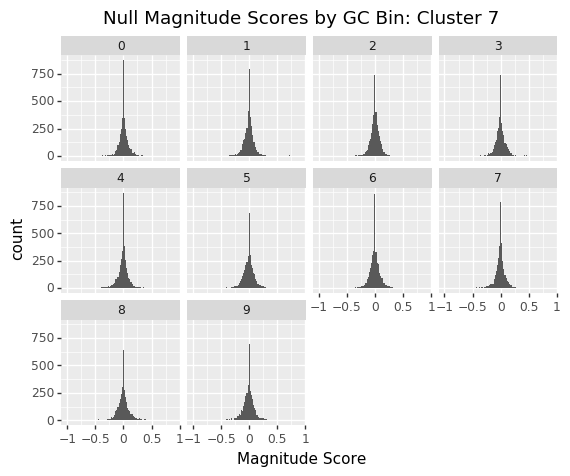

<ggplot: (8764922657684)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.0025519494552928854
Stdev: 	 0.05179031854295183

KstestResult(statistic=0.04282916868375386, pvalue=1.2649736969836272e-57)



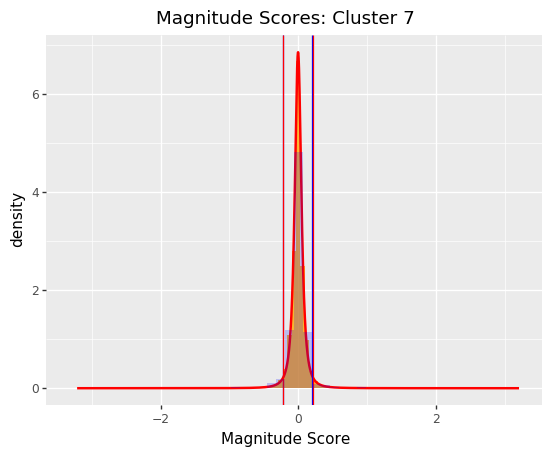

<ggplot: (-9223363271933744892)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

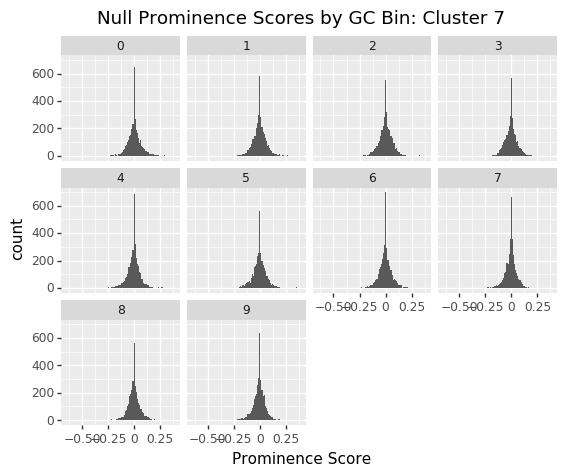

<ggplot: (8764921441288)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0020188614971344493
Stdev: 	 0.04076057668699556

KstestResult(statistic=0.040437121803253984, pvalue=2.0553374969503165e-51)



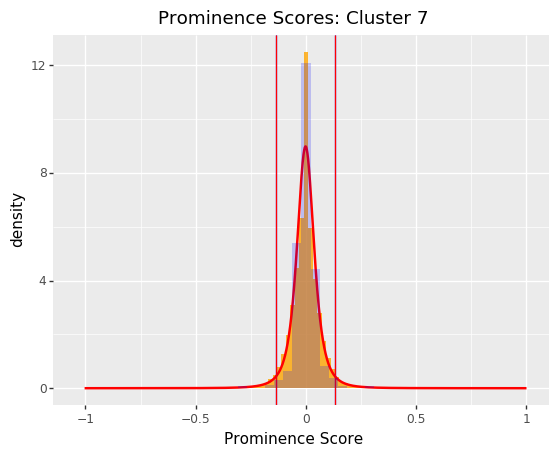

<ggplot: (8764921797622)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.002977889861435344
Stdev: 	 0.008689202562928568



KstestResult(statistic=0.016097674725776723, pvalue=1.6562068381016838e-225)



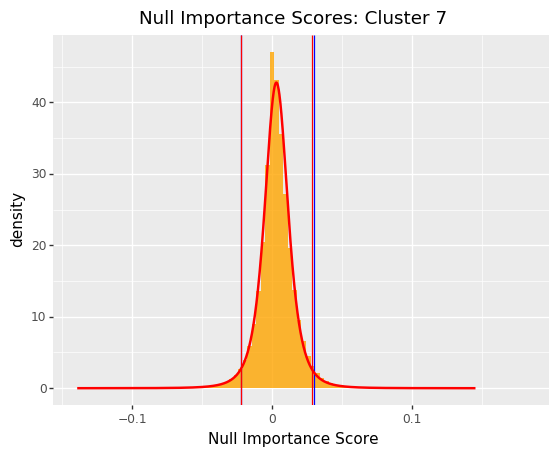

<ggplot: (-9223363271924286923)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-Values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
snp_scores.sort_values(by=['confidence'], ascending=False, inplace=True)
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/overlap_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.overlap.snp_scores.tsv', sep='\t', index=False)
idr_snp_scores = snp_scores.loc[snp_scores['in_idr_peak'] == True].copy()
idr_snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/idr_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.idr.snp_scores.tsv', sep='\t', index=False)
sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NA']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NA']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)
idr_unique_sig_snps = unique_sig_snps.loc[unique_sig_snps['in_idr_peak'] == True].copy()

print('Unique Significant SNPs:')
print()
display(idr_unique_sig_snps)
print()
print('Shape: ', idr_unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(idr_unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Scored: ', '\t', '\t', '\t', '\t', len(idr_snp_scores))
print('Unique SNPs Scored: ', '\t', '\t', '\t', '\t', len(idr_snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,in_idr_peak,active_seqlet,inactive_seqlet,diff_seqlet,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
37,chr11,86103987,86103988,rs1237999,A,G,G,A,A,G,+,16,0.339,-1.034727,-1.612460,-9.232664,-0.866652,-0.272231,0,Alzheimers_Jansen_2018,7.140000e-16,False,True,TATGAGTCACC,TATAAGTCACC,TAT(G/A)AGTCACC,noneffect,0.000253,0.000181,0.000193,0.000223,0.003008,2
213,chr19,44644418,44644419,rs10426401,G,T,T,G,T,G,-,71,0.615,0.427940,0.682147,3.916541,0.268368,0.143954,7,Alzheimers_Jansen_2018,4.630000e-14,True,True,GGGGCGG,GGGTCGG,GGG(G/T)CGG,effect,0.037433,0.028342,0.029130,0.024735,0.036156,2
351,chr5,103120549,103120550,rs26523,T,C,C,T,C,T,-,104,0.543,-0.423935,-0.662445,-3.822424,-0.297873,-0.142344,4,Nalls_23andMe,1.084830e-03,False,True,AGGCGGCTGC,AGGTGGCTGC,AGG(C/T)GGCTGC,noneffect,0.043579,0.035962,0.036173,0.023510,0.044958,2
305,chr3,52498433,52498434,rs181391313,G,A,G,A,G,A,-,93,0.591,0.544716,0.851825,4.899941,0.235684,0.128171,6,Chang_23andMe_Parkinsons,2.730650e-03,False,True,GGCGGAG,GGCAGAG,GGC(G/A)GAG,effect,0.012739,0.009955,0.010183,0.035042,0.052089,1
187,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.693,0.473333,0.751622,4.308969,0.399485,0.125335,9,23andme_PD_hg38,9.490000e-14,True,True,GCGCCACCTACA,GAGCCACCTACA,G(C/A)GCCACCTACA,effect,0.024582,0.018416,0.019103,0.008468,0.055877,1
177,chr17,46038519,46038520,rs12150090,T,C,C,"G,T",C,"G,T",-,54,0.489,0.547247,0.855002,4.961629,0.293403,0.125295,3,23andme_PD_hg38,2.508350e-22,True,True,CCAATCC,CCAACCC,CCAA(T/C)CC,effect,0.012448,0.009764,0.009542,0.019387,0.055933,1
97,chr17,45639518,45639519,rs413778,G,A,A,G,A,G,-,54,0.461,0.482934,0.752221,4.400092,0.407201,0.105535,1,23andme_PD_hg38,2.960000e-22,True,True,GCTGGTGAGTCAGA,GCTGGTGAGTCAAA,GCTGGTGAGTCA(G/A)A,effect,0.022492,0.018348,0.017326,0.008134,0.087688,1
13,chr10,80493944,80493945,rs7900536,A,C,C,"A,T",A,"C,T",+,5,0.442,0.517999,0.805977,4.786679,0.491915,0.104506,1,Alzheimers_Kunkle_2019,2.910000e-05,True,True,CCTCTAGAGGGATGATTCAGA,CCTCTAGAGGGATGATTCCGA,CCTCTAGAGGGATGATTC(A/C)GA,effect,0.016276,0.013174,0.011478,0.004735,0.089359,1
298,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.658,-0.410581,-0.647115,-3.729726,-0.353754,-0.103251,8,Nalls_23andMe,2.349340e-03,False,True,GAGGGCGCTGT,GAGGGTGCTGT,GAGGG(C/T)GCTGT,noneffect,0.049297,0.039556,0.039967,0.015320,0.106741,1
265,chr2,95323523,95323524,rs3755519,T,A,A,"C,G,T",T,"A,C,G",+,85,0.639,-0.556713,-0.877065,-5.053239,-0.258338,-0.073713,8,Nalls_23andMe,7.682450e-03,False,True,AGTGCTCTCTGC,TGTGCTCTCTGC,(A/T)GTGCTCTCTGC,noneffect,0.012789,0.009560,0.009698,0.034095,0.205237,1



Shape:  (11, 33)

SNPs with Significant Scores: 	 	 	 11
Significant SNPs with Low Confidence: 	 	 1
Significant SNPs with Moderate Confidence: 	 7
Significant SNPs with High Confidence: 	 	 3

Total SNPs Scored:  	 	 	 	 368
Unique SNPs Scored:  	 	 	 	 330


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 37

RSID: rs1237999 	 	 || 	 chr11 : 86103987 - 86103988 	 || 	 Locus: 16

GWAS: Alzheimers_Jansen_2018 	 || 	 GWAS P-Value: 7.1400E-16 	 || 	 Coloc: False

Prominence P-Value: 3.0084E-03 	 || 	 Magnitude P-Value: 2.2284E-04 	 || 	 Confidence: 2

GkmExplain P-Value: 2.5293E-04 	 || 	 ISM P-Value: 1.8141E-04 	 || 	 deltaSVM P-Value: 1.9268E-04

----------------------------------------------------------------------------------------------------

Non-Effect Allele: G 	 	 || 	 Active Seqlet: TATGAGTCACC



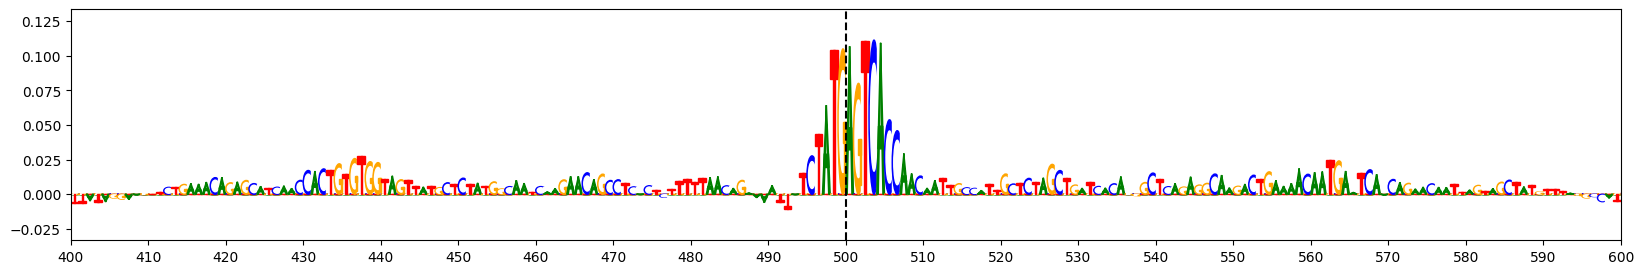


Effect Allele: A 	 	 || 	 Inactive Seqlet: TATAAGTCACC



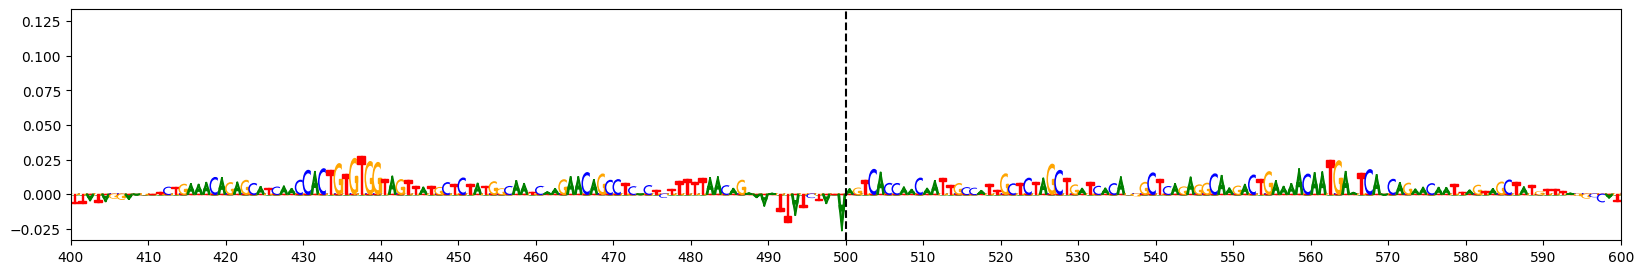


Difference Seqlet: TAT(G/A)AGTCACC



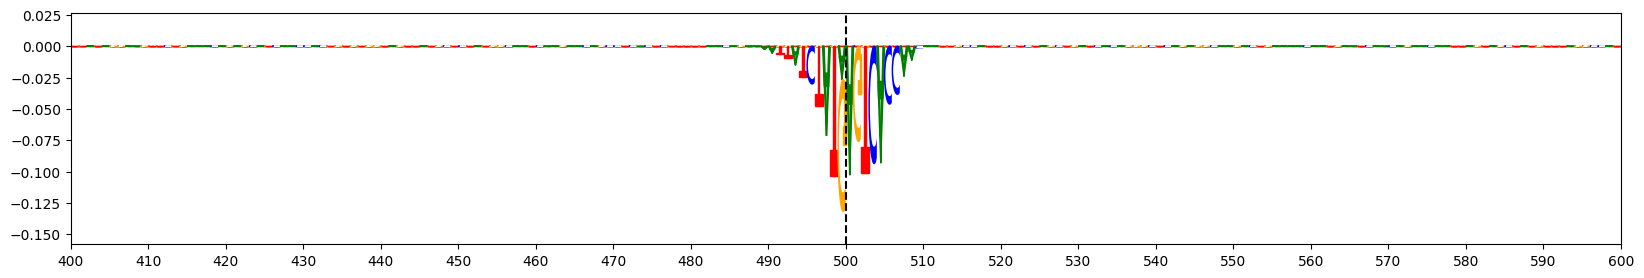


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 213

RSID: rs10426401 	 	 || 	 chr19 : 44644418 - 44644419 	 || 	 Locus: 71

GWAS: Alzheimers_Jansen_2018 	 || 	 GWAS P-Value: 4.6300E-14 	 || 	 Coloc: True

Prominence P-Value: 3.6156E-02 	 || 	 Magnitude P-Value: 2.4735E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 3.7433E-02 	 || 	 ISM P-Value: 2.8342E-02 	 || 	 deltaSVM P-Value: 2.9130E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Seqlet: GGGGCGG



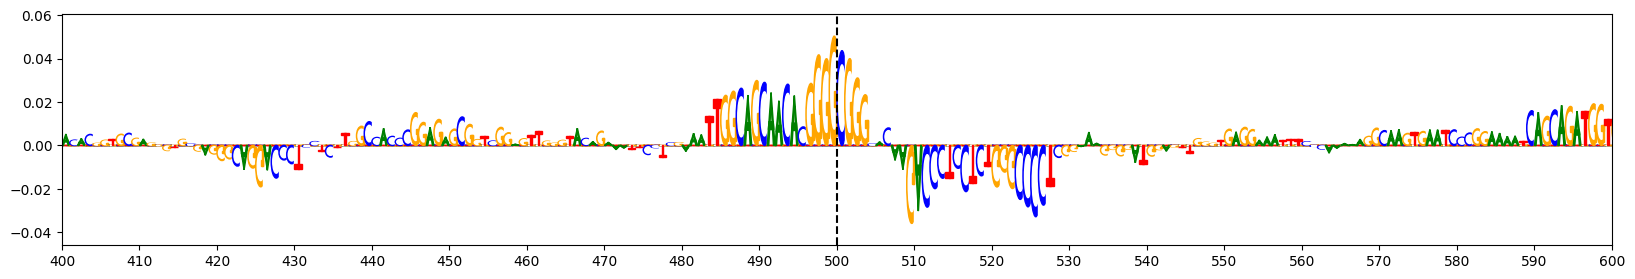


Non-Effect Allele: T 	 	 || 	 Inactive Seqlet: GGGTCGG



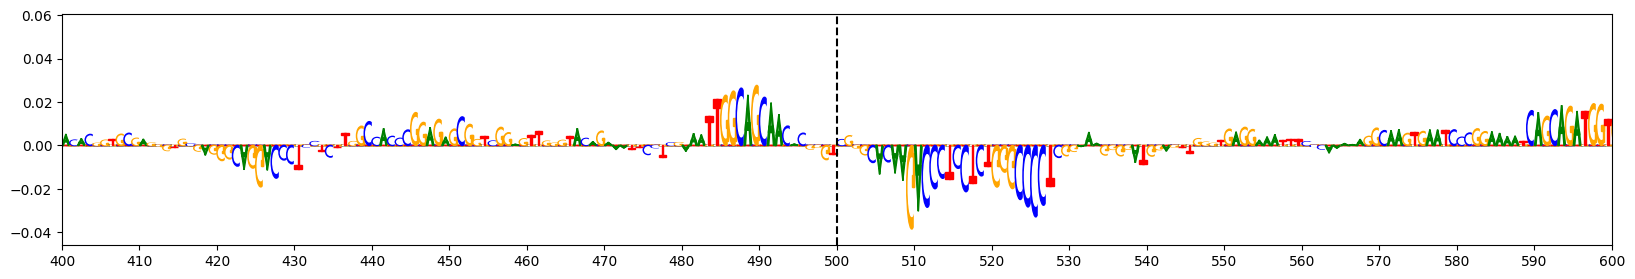


Difference Seqlet: GGG(G/T)CGG



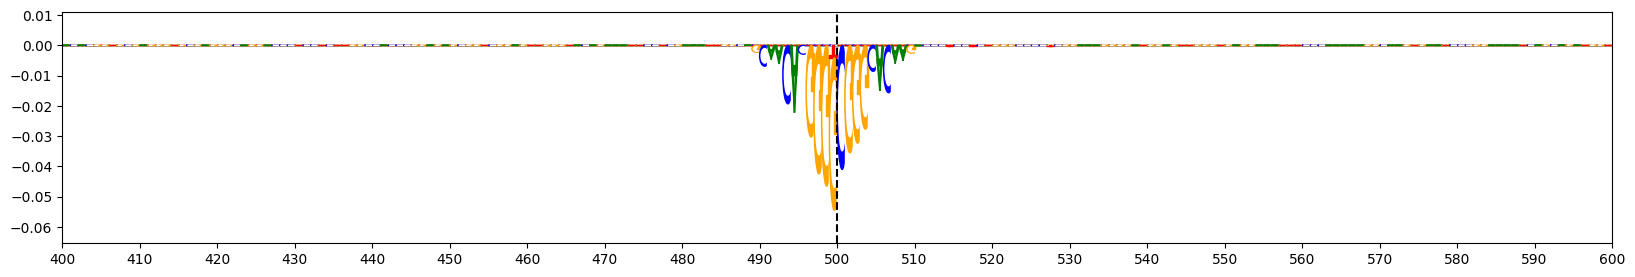


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 351

RSID: rs26523 	 	 || 	 chr5 : 103120549 - 103120550 	 || 	 Locus: 104

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 1.0848E-03 	 || 	 Coloc: False

Prominence P-Value: 4.4958E-02 	 || 	 Magnitude P-Value: 2.3510E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 4.3579E-02 	 || 	 ISM P-Value: 3.5962E-02 	 || 	 deltaSVM P-Value: 3.6173E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: AGGCGGCTGC



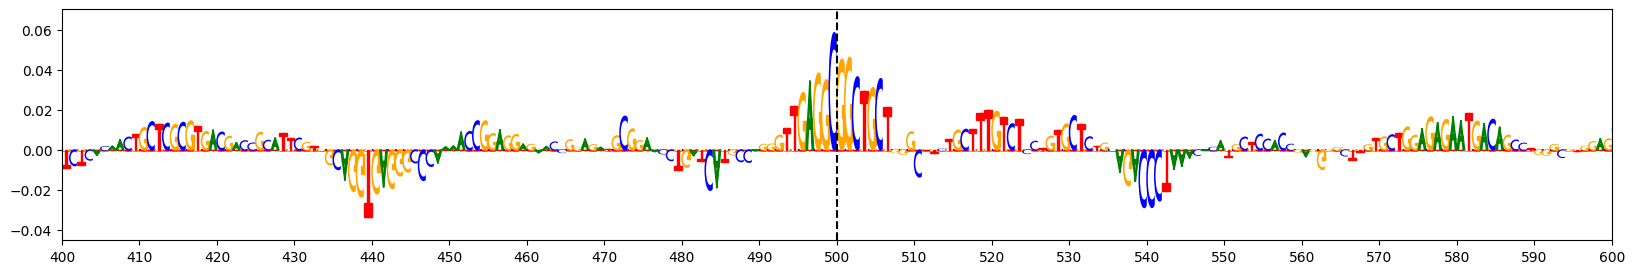


Effect Allele: T 	 	 || 	 Inactive Seqlet: AGGTGGCTGC



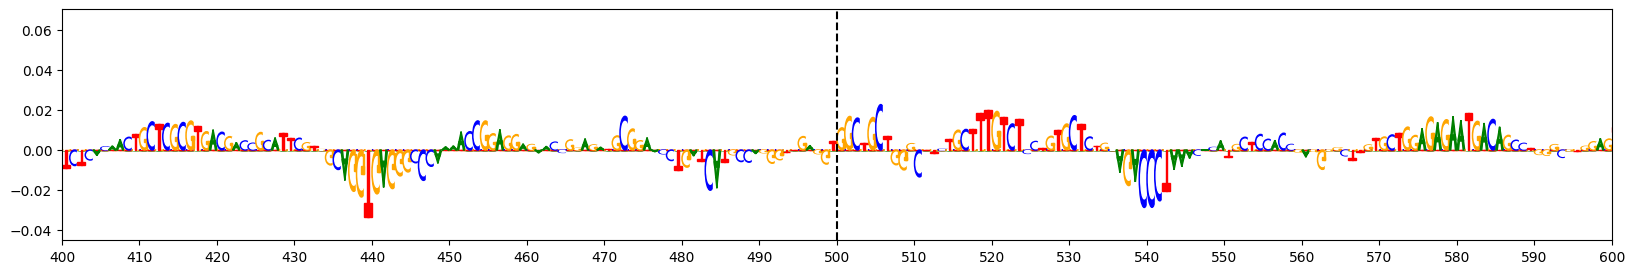


Difference Seqlet: AGG(C/T)GGCTGC



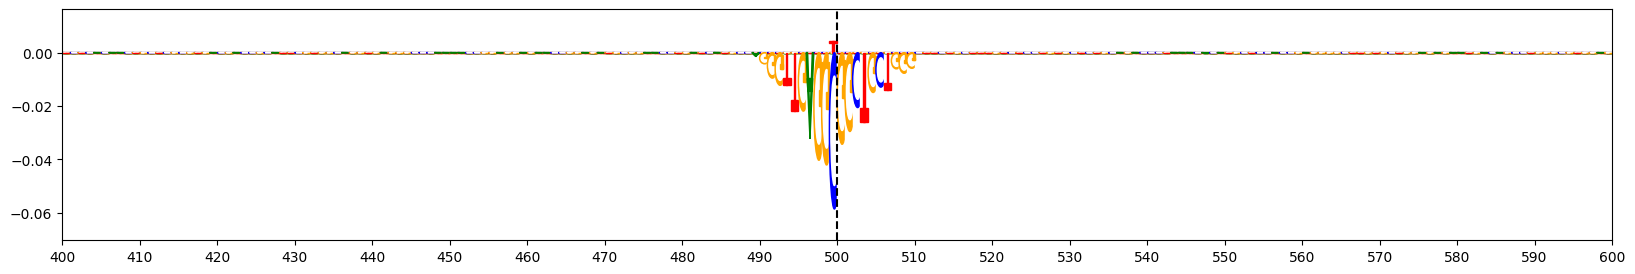


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'GWAS P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Seqlet:', row['diff_seqlet'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_observed_noneffect_scores[index] - merged_observed_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_observed_effect_scores[index] - merged_observed_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in idr_unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
idr_unique_sig_snps['fc_track'] = fc_tracks
idr_unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15045857429504395
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.12786102294921875
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16105151176452637
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15097546577453613
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15424060821533203
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1845545768737793
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.18445467948913574
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15492558479309082
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1910717487335205
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16338109970092773
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20681166648864746
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15169286727905273
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15584444999694824
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.21156072616577148
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17894506454467773
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.14398956298828125
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15802574157714844
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15773797035217285
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.14578938484191895
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15133190155029297
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1556262969970703
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16180801391601562
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = idr_unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc', 'in_idr_peak',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_seqlet', 'diff_seqlet', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.idr.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)
print()
print('Shape: ', final_sig_snps.shape)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,in_idr_peak,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_seqlet,diff_seqlet,active_allele,fc_track,pval_track
37,chr11,86103987,86103988,rs1237999,A,G,A,G,+,16,Alzheimers_Jansen_2018,7.140000e-16,False,True,0.000253,0.000181,0.000193,0.000223,0.003008,2,TATGAGTCACC,TAT(G/A)AGTCACC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
213,chr19,44644418,44644419,rs10426401,G,T,T,G,-,71,Alzheimers_Jansen_2018,4.630000e-14,True,True,0.037433,0.028342,0.029130,0.024735,0.036156,2,GGGGCGG,GGG(G/T)CGG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
351,chr5,103120549,103120550,rs26523,T,C,C,T,-,104,Nalls_23andMe,1.084830e-03,False,True,0.043579,0.035962,0.036173,0.023510,0.044958,2,AGGCGGCTGC,AGG(C/T)GGCTGC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
305,chr3,52498433,52498434,rs181391313,G,A,G,A,-,93,Chang_23andMe_Parkinsons,2.730650e-03,False,True,0.012739,0.009955,0.010183,0.035042,0.052089,1,GGCGGAG,GGC(G/A)GAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
187,chr17,46771150,46771151,rs199523,C,A,A,C,-,54,23andme_PD_hg38,9.490000e-14,True,True,0.024582,0.018416,0.019103,0.008468,0.055877,1,GCGCCACCTACA,G(C/A)GCCACCTACA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
177,chr17,46038519,46038520,rs12150090,T,C,C,"G,T",-,54,23andme_PD_hg38,2.508350e-22,True,True,0.012448,0.009764,0.009542,0.019387,0.055933,1,CCAATCC,CCAA(T/C)CC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
97,chr17,45639518,45639519,rs413778,G,A,A,G,-,54,23andme_PD_hg38,2.960000e-22,True,True,0.022492,0.018348,0.017326,0.008134,0.087688,1,GCTGGTGAGTCAGA,GCTGGTGAGTCA(G/A)A,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
13,chr10,80493944,80493945,rs7900536,A,C,A,"C,T",+,5,Alzheimers_Kunkle_2019,2.910000e-05,True,True,0.016276,0.013174,0.011478,0.004735,0.089359,1,CCTCTAGAGGGATGATTCAGA,CCTCTAGAGGGATGATTC(A/C)GA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
298,chr3,49007333,49007334,rs6781790,T,C,T,C,+,92,Nalls_23andMe,2.349340e-03,False,True,0.049297,0.039556,0.039967,0.015320,0.106741,1,GAGGGCGCTGT,GAGGG(C/T)GCTGT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
265,chr2,95323523,95323524,rs3755519,T,A,T,"A,C,G",+,85,Nalls_23andMe,7.682450e-03,False,True,0.012789,0.009560,0.009698,0.034095,0.205237,1,AGTGCTCTCTGC,(A/T)GTGCTCTCTGC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...



Shape:  (11, 25)
